# Radix-2 Cooley-Tukey

In [1]:
%run ../setup.ipynb

As mentioned in the introduction to this chapter, there are many algorithms which are collectively referred to as "Fast Fourier Transforms".
In this section, we'll see one of the earliest methods, (re-)discovered in 1965 by Cooley and Tukey {cite}`cooley1965algorithm`, which can accelerate DFT calculations when $N$ is an integral power of 2: $N = 2^K$.

```{margin}
The Cooley-Tukey method for DFT calculation was known to Gauss all the way back in the early 19th century.

What a clever chap.
```

Modern FFT implementations use many tricks to speed up calculation, and generalize to arbitrary values for $N$.
That said, the core idea of the "radix-2 Cooley-Tukey" method has plenty of interest to offer, and sheds some light on how more advanced techniques can be developed.

## Divide and Conquer

We'll start again with the DFT equation:

```{math}
\darkblue{X[m]} = \sum_{n=0}^{N-1} \blue{x[n]} \cdot \purple{e^{-2\pi \cdot \mathrm{j} \cdot m \cdot n / N}}.
```

The key observation of Cooley and Tukey is that this summation can be broken apart in interesting ways.
Specifically, we can separate the summation into *even indices* $n=0,2,4,\dots$ and odd indices $n=1,3,5,\dots$.

In [1]:
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch

fig = plt.figure(figsize=figaspect(0.5))

N = 32

m = 2
n = np.arange(N)
x = np.cos(2 * np.pi * m * n / N - np.pi / 3)

gs = fig.add_gridspec(3, 4)

ax0 = fig.add_subplot(gs[0, :])
ax0.set(xlim=[-1, N], ylim=[-1.25, 1.25], xticks=[], yticks=[0], yticklabels=[])
ax0.step(n, x, color=colors[3], where='post', marker='o')
ax0.plot(n[::2], x[::2], color=colors[0], marker='o', markersize=14, zorder=-10, linestyle='', markeredgewidth=2)
ax0.plot(n[1::2], x[1::2], color=colors[1], marker='o', markersize=14, zorder=-10, linestyle='', markeredgewidth=2)
ax0.label_outer()

# Second row
ax1 = fig.add_subplot(gs[1, :2], sharex=ax0, sharey=ax0)
ax1.step(n[::2], x[::2], color=colors[0], where='post', marker='o')
ax1.plot(n[::4], x[::4], color=colors[2], marker='o', markersize=14, zorder=-10, linestyle='', markeredgewidth=2)
ax1.plot(n[2::4], x[2::4], color=colors[4], marker='o', markersize=14, zorder=-10, linestyle='', markeredgewidth=2)
ax1.label_outer()

# Connect the first three samples
for i in range(0, 6, 2):
    p = ConnectionPatch((n[i], x[i]), (n[i], x[i]), 'data', connectionstyle="arc3,rad=-0.25", arrowstyle="<-",
                        axesA=ax1, axesB=ax0, color=colors[0], alpha=0.5, zorder=-1, linewidth=2)
    fig.add_artist(p)

ax2 = fig.add_subplot(gs[1, 2:], sharex=ax0, sharey=ax0)
ax2.step(n[1::2], x[1::2], color=colors[1], where='post', marker='o')
ax2.plot(n[1::4], x[1::4], color=colors[7], marker='o', markersize=14, zorder=-10, linestyle='', markeredgewidth=2)
ax2.plot(n[3::4], x[3::4], color=colors[10], marker='o', markersize=14, zorder=-10, linestyle='', markeredgewidth=2)
ax2.label_outer()
# Connect last three samples
#for i in range(N-5, N, 2):
for i in range(1, 7, 2):
    p = ConnectionPatch((n[i], x[i]), (n[i], x[i]), 'data', connectionstyle="arc3,rad=-0.25", arrowstyle="<-",
                        axesA=ax2, axesB=ax0, color=colors[1], alpha=0.5, zorder=-1, linewidth=2)
    fig.add_artist(p)

    
# Third row

ax3 = fig.add_subplot(gs[2, 0], sharex=ax0, sharey=ax0)
ax3.step(n[::4], x[::4], color=colors[2], where='post', marker='o')
ax3.label_outer()

for i in range(0, 12, 4):
    p = ConnectionPatch((n[i], x[i]), (n[i], x[i]), 'data', connectionstyle="arc3,rad=-0.25", arrowstyle="<-",
                        axesA=ax3, axesB=ax1, color=colors[2], alpha=0.5, zorder=-1, linewidth=2)
    fig.add_artist(p)

ax4 = fig.add_subplot(gs[2, 1], sharex=ax0, sharey=ax0)
ax4.step(n[2::4], x[2::4], color=colors[4], where='post', marker='o')
ax4.label_outer()
# Connect the last three samples
#for i in range(N-10, N, 4):
for i in range(2, 14, 4):
    p = ConnectionPatch((n[i], x[i]), (n[i], x[i]), 'data', connectionstyle="arc3,rad=0.25", arrowstyle="<-",
                        axesA=ax4, axesB=ax1, color=colors[4], alpha=0.5, zorder=-1, linewidth=2)
    fig.add_artist(p)

ax5 = fig.add_subplot(gs[2, 2], sharex=ax0, sharey=ax0)
ax5.step(n[1::4], x[1::4], color=colors[7], where='post', marker='o')
ax5.label_outer()

for i in range(1, 13, 4):
    p = ConnectionPatch((n[i], x[i]), (n[i], x[i]), 'data', connectionstyle="arc3,rad=-0.25", arrowstyle="<-",
                        axesA=ax5, axesB=ax2, color=colors[7], alpha=0.5, zorder=-1, linewidth=2)
    fig.add_artist(p)

ax6 = fig.add_subplot(gs[2, 3], sharex=ax0, sharey=ax0)
ax6.step(n[3::4], x[3::4], color=colors[10], where='post', marker='o')
ax6.label_outer()
#for i in range(N-9, N, 4):
for i in range(3, 15, 4):
    p = ConnectionPatch((n[i], x[i]), (n[i], x[i]), 'data', connectionstyle="arc3,rad=0.25", arrowstyle="<-",
                        axesA=ax6, axesB=ax2, color=colors[10], alpha=0.5, zorder=-1, linewidth=2)
    fig.add_artist(p)

fig.text(0.5, 0, '$\dots$', size=30, ha='left', va='top')

glue('dft-recurse', fig, display=False)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_188223/1362993818.py:4 in <cell line: 4>                                   │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_188223/1362993818.py'                │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'plt' is not defined

```{glue:figure} dft-recurse
:alt: a signal recursively divided by taking alternating samples

A discrete signal $x[n]$ of $N=32$ samples (top row) is divided into its *even* and *odd* samples (middle-left and middle-right).
The even and odd signals themselves can be similarly divided (bottom row).
This process can repeat up to $\log_2 N$ times.
```

Writing $n=2k$ for even and $n=2k+1$ for odd indices, we get:

```{math}
\darkblue{X[m]} = \underbrace{\sum_{k=0}^{N/2-1} \blue{x[2k]} \cdot \purple{e^{-2\pi \cdot \mathrm{j} \cdot m \cdot 2k / N}}}_\text{Even part}
\quad + 
\underbrace{\sum_{k=0}^{N/2-1} \blue{x[2k+1]} \cdot \purple{e^{-2\pi \cdot \mathrm{j} \cdot m \cdot (2k+1) / N}}}_\text{Odd part}
```

All we've done so far is change variables: the summations are identical to the original definition.
However, if we notice that $2k / N = k / (N/2)$, we can interpret the first summation as the DFT $\magenta{X_E[m]}$ where $\purple{x_E[n]} = \blue{x[2n]}$ is the signal comprised of the even-numbered samples:

```{math}
\sum_{k=0}^{N/2-1} \blue{x[2k]} \cdot \purple{e^{-2\pi \cdot \mathrm{j} \cdot m \cdot 2k / N}}
\quad =
\sum_{k=0}^{N/2-1} \blue{x[2k]} \cdot \purple{e^{-2\pi \cdot \mathrm{j} \cdot m \cdot k / (N/2)}}
```

This trick doesn't exactly work for the odd-part summation, but we can make it work with a little arithmetic.
Observe that by the rule of exponents $e^{a+b} = e^a \cdot e^b$,
```{math}
\purple{e^{-2\pi \cdot \mathrm{j} \cdot m \cdot (2k+1) / N}}
\quad = 
\purple{\left({e^{-2\pi \cdot \mathrm{j} \cdot m \cdot 2k / N}\;\;\;\;} \right)} \cdot \red{\left({e^{-2\pi \cdot \mathrm{j} \cdot m / N}\;\;\;}\right)}.
```

The first factor is exactly the same as in the even case, and gives us the DFT basis.
The second factor, $\red{e^{-2\pi \cdot \mathrm{j} \cdot m / N}\;\;}$ (commonly called a *"twiddle factor"*) does not depend on the variable of summation ($k$), and can therefore be factored out of the sum, giving us:

```{math}
\sum_{k=0}^{N/2-1} \blue{x[2k+1]} \cdot \purple{e^{-2\pi \cdot \mathrm{j} \cdot m \cdot (2k+1) / N}}
\quad =
\red{\left({e^{-2\pi \cdot \mathrm{j} \cdot m / N}}\;\;\right)} \cdot \sum_{k=0}^{N/2-1} \blue{x[2k+1]} \cdot \purple{e^{-2\pi \cdot \mathrm{j} \cdot m \cdot k / (N/2)}}
```

This says that the second summation is the DFT $\magenta{X_O[m]}$ of the signal comprised of odd-indexed samples $\purple{x_O[n]} = \blue{x[2n+1]}$, with an additional rotation of $\red{-2\pi \cdot m / N}$.

Combining these two observations, we can express the original DFT of $N$ samples in terms of two DFTs of $N/2$ samples:

```{margin}
Note that the multiplicative factor $\red{e^{-2\pi\cdot\mathrm{j}\cdot m / N}}$ is exactly what we would get from the {ref}`DFT shifting theorem <shifting-theorem>` when $\purple{x_O}$ is delayed by one sample.
```

```{math}
---
label: eq-fft
---
\darkblue{X[m]} = \magenta{X_E[m]} + \red{\left({e^{-2\pi \cdot \mathrm{j} \cdot m / N}}\;\;\right)} \cdot \magenta{X_O[m]}
```

This expression is an example of the [**divide-and-conquer**](https://en.wikipedia.org/wiki/Divide-and-conquer_algorithm) approach to problem solving.
When given a large problem to solve, it sometimes helps to break it into smaller problems whose solutions can be combined to solve the original problem.

### Why is this helpful?

So far, all we've done is express a single component of the DFT $\darkblue{X[m]}$ *recursively* in terms of two smaller DFT's, $\magenta{X_E[m]}$ and $\magenta{X_O[m]}$.
If we only cared about computing a single frequency index $m$, this recursive formulation wouldn't help us.
Remember, we can compute a single DFT coefficient $\darkblue{X[m]}$ in $N$ steps (the inner loop of the naive algorithm in the previous section), and we know that it can't be done in fewer than $N$ steps because each sample $x[n]$ must be looked at.

Of course, we're usually interested in computing the full DFT (all $N$ frequencies).
The recursive decomposition of $\darkblue{X[m]}$ is helpful here because it applies simultaneously to *all frequencies* $m = 0, 1, 2, \dots, N-1$.
That is, if someone gave us the entire DFT calculations for $\magenta{X_E}$ and $\magenta{X_O}$, we could compute the entire DFT $\magenta{X}$ in $N$ additional steps by applying {eq}`eq-fft` (once for each $m=0,1,2,\dots,N-1$).
In principle, we should be able to do something like the following:

````{margin}
```{warning}
The pseudo-code here does not quite work, for reasons given below.
But it should give you a sense of how smaller DFTs can be combined to produce the full DFT.
```
````
```{code-block} python
---
lineno-start: 1
---

def pseudo_fft(x, X_E, X_O):
    '''Compute the DFT of x given the even and odd DFTs X_E, X_O'''
    
    N = len(x)
            
    # Combine the given even and odd spectra
    X = np.zeros(N, dtype=np.complex)
    
    for m in range(N):
        X[m] = X_E[m] + np.exp(-2j * np.pi * m / N) * X_O[m]
        
    return X
```

In reality, we won't get $\magenta{X_E}$ and $\magenta{X_O}$ for free.
However, if the total work taken to get $\magenta{X_E}$ and $\magenta{X_O}$ is less than the naive algorithm's $N^2$, this still amounts to an improvement.

## How many frequencies?

A careful look at {eq}`eq-fft` reveals something a little strange: the DFT $\darkblue{X[m]}$ involves $N$ frequencies ($m=0,1,2,\dots, N-1$), while the smaller DFTs $\magenta{X_E[m]}$ and $\magenta{X_O[m]}$ should have only $N/2$ frequencies ($m=0,1,2,\dots,N/2-1$) since they are derived from signals of length $N/2$.
This introduces a problem for lines 9--10 in the code block above: how do we recover all $N$ frequencies when only $N/2$ are present in $\magenta{X_E}$ and $\magenta{X_O}$?

Once again, **aliasing** can come to the rescue.

Recall that each $\darkblue{X[m]}$ is the result of a comparison to a wave that completes $\red{m}$ cycles in $\blue{N}$ samples, or in units of Hz:
```{math}
\red{f_m} = \frac{\red{m}}{\blue{N}} \cdot f_s.
```

For {eq}`eq-fft` to make sense, $\magenta{X_E[m]}$ should involve a comparison to a wave that complete $\red{m}$ cycles in $\blue{N' = N/2}$ samples.
Note, however, that the sampling rate for the even signal $\purple{x_E}$ is $f'_s = f_s/2$ because the period between samples is double that of our original signal $\blue{x}$.
If $\red{m} \geq N/2$, the aliasing equation {eq}`aliasing-eqn` tells us that this frequency has an aliasing frequency $\red{f_a}$ given by:

\begin{align*}
\red{f_a} &= \frac{\red{m}}{\blue{N'}} \cdot f'_s - f'_s &\\
&= \frac{\red{m}}{\blue{N/2}}\cdot \frac{f_s}{2} - \frac{f_s}{2}\\
&= \frac{\red{m}}{\blue{N}} \cdot f_s - \frac{f_s}{2}\\
&= \frac{\red{m} - \blue{N/2}}{\blue{N}} \cdot f_s.
\end{align*}

In plain words, this says that to find $\magenta{X_E[m]}$ for $\red{m} \geq N/2$, we should look at the DFT coefficient $\magenta{X_E[m - N/2]}$.
This is relationship is depicted visually in {numref}`fft-alias`.

<Figure size 720x144 with 1 Axes>

<Figure size 720x144 with 1 Axes>

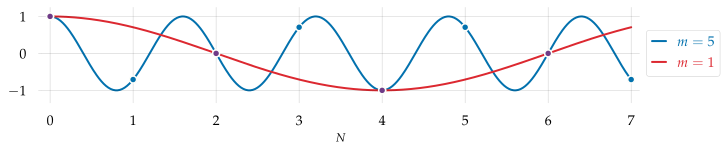

In [26]:
fig, ax = plt.subplots(figsize=figaspect(0.2))
N = 8
m = 5

n = np.arange(N)
t = np.linspace(0, N-1, num=500)
x = np.cos(2 * np.pi * m / N * n)
xc = np.cos(2 * np.pi * m * t / N)
xca = np.cos(2 * np.pi * (m - N//2) * t / N)
ax.plot(t, xc, zorder=-1, label=f'$m={m}$')
ax.plot(t, xca, zorder=-1, label=f'$m={m-N//2}$')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelcolor='linecolor')
ax.plot(n, x, marker='o', linestyle='', color=colors[0])
ax.plot(n[::2], x[::2], marker='o', color=colors[4], zorder=5, linestyle='')
ax.set(xlabel='$N$', xlim=[-0.1, N-0.9], ylim=[-1.25, 1.25])
glue('fft-alias', fig, display=False)

```{glue:figure} fft-alias
---
name: fft-alias
alt: decimation in time produces aliasing
---

A wave at $\blue{m} = N/2 + 1$ (with $N=8$, $\blue{m}=5$) is decimated by taking only the even-index samples $n=0, 2, 4, \dots$.
Due to aliasing, the resulting sequence is equivalent to a wave at $\red{m - N/2 = 1}$.
```

Frequency indices $\red{m} < N/2$ do not need special aliasing treatment, as they will occur exactly where we expect them to in the DFT spectrum: $\magenta{X_E[m]}$.

We can notationally combine these two cases ($<N/2$ and $\geq N/2$) as

```{math}
\red{m} \rightarrow \left( \red{m} \mod \frac{\blue{N}}{2} \right),
```

or, in Python code:

```python
m % (N //2)
```

This allows us to correctly state the expression of $\darkblue{X[m]}$ in terms of $\magenta{X_E}$ and $\magenta{X_O}$ for all $\red{m}$:

```{math}
\darkblue{X[m]} = \magenta{X_E\left[m \mod \frac{N}{2}\right]} + 
\red{\left({e^{-2\pi \cdot \mathrm{j} \cdot m / N}}\;\;\right)} \cdot \magenta{X_O\left[m \mod \frac{N}{2}\right]}.
```

The benefit of this form is that we only rely on $N/2$ coefficients in both $\magenta{X_E}$ and $\magenta{X_O}$, but we are still able to recover all $N$ coefficients $\darkblue{X[m]}$.
This, ultimately, is the source of the efficiency gains in FFT algorithms: the solutions to smaller sub-problems can be used multiple times to produce different parts of the output. $\darkblue{X[m]}$ and $\darkblue{X[m + N/2]}$ both depend on $\magenta{X_E[m]}$ and $\magenta{X_O[m]}$.
We compute $\magenta{X_E}$ and $\magenta{X_O}$ once, but we get to use them twice.

## A radix-2 algorithm

Finally, combining the observations above, we can give a full definition of the radix-2 FFT algorithm.

The last ingredient to this algorithm, compared to the naive DFT implementation, is *recursion*.
To compute $\magenta{X_E}$ and $\magenta{X_O}$, the algorithm will **call itself** on the appropriately sub-sampled signal.
Once it has $\magenta{X_E}$ and $\magenta{X_O}$, it then combines the results and returns the output spectrum.

```{margin} Recursion is weird.

If you've never seen recursion before, don't panic.

Yes, it's weird, but it's not magic.

If it helps, think of a simpler recursive algorithm for adding up a list of numbers.
You can think of any such sum as "the first number, plus whatever the sum of the rest is".
That definition also applies to the "sum of the rest" part, and every subsequent sum until there is only a single number left.
```

If the input has only one sample ($N = 2^0 = 1$), then there is only one analysis frequency ($m=0$), and $X[0] = x[0]$ is just the sample value itself.
This represents the **base case**, the input which terminates the recursion.

(radix2-fft)=
```{code-block} python
---
lineno-start: 1
---

def fft2(x):
    '''Compute the DFT of an input x of N = 2**k samples'''
    
    # Get the length of the input
    N = len(x)
    
    # The DFT of a single sample is just the sample value itself
    # Nothing else to do here, so return
    if N == 1:
        return x
        
    else:
        # Recursively compute the even and odd DFTs
        X_even = fft2(x[0::2])  # Start at 0 with steps of 2
        X_odd = fft2(x[1::2])  # Start at 1 with steps of 2
        
        # Allocate the output array
        X = np.zeros(N, dtype=np.complex)
        
        # Combine the even and odd parts
        for m in range(N):
            # Find the alias of frequency m in the smaller DFTs
            m_alias = m % (N//2)
            X[m] = X_even[m_alias] + np.exp(-2j * np.pi * m / N) * X_odd[m_alias]
            
        return X
```

### Time analysis

Analyzing the running time of the `fft2` algorithm above requires a slightly more sophisticated approach than the naive DFT algorithm, due to the use of recursion.

Let $T(N)$ represent the amount of time taken by the algorithm on an input of length $N$.
For now, $T(N)$ is an unknown quantity, but this notation will help us solve for it.
We're not going to aim for a precise count of the operations performed by the algorithm, but merely a coarse upper bound on how the computation scales with the length of the input ($N$).

The base case, $T(1)$, takes some constant amount of time, which we can call $c$.
This accounts for all computation up to line 10 where it returns from the $N=1$ case.

If $N>1$, then we see two recursive calls to inputs of length $N/2$.
This is followed by a loop of $N$ steps (line 21), of which each step takes some constant amount of time that we'll call $d$, for a total of $N\cdot d$.
(We'll absorb the amount of time to allocate the output array at line 18 into this quantity.)
Using this observation, we can express the total time for $T(N)$ recursively:

```{math}
T(N) = 2 \cdot T\left(\frac{N}{2}\right) + N\cdot d
```

Each of these recursive calls, in turn has two more recursive calls plus $d\cdot N/2$ work to combine the results:

```{math}
T(N) = 2 \cdot \left( 2\cdot T\left(\frac{N}{4}\right) + \frac{N}{2} \cdot d \right)+ N\cdot d
```

and this process can repeat until the recursion stops at $N=1$.

If we total up the non-recursive computation done at each *level* of the recursion, we can get a handle on the total amount of computation.
This is illustrated in {numref}`fig-recursion`.
To simplify notation, we'll assume that $c \leq d$, meaning that the arithmetic operations at lines 23--24 are more expensive than the base-case operations in lines 1--10.

<Figure size 432x216 with 1 Axes>

<Figure size 432x216 with 1 Axes>

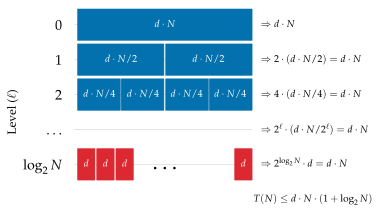

In [19]:
from matplotlib.collections import BrokenBarHCollection

fig, ax  = plt.subplots(figsize=figaspect(0.5))
height = 0.45

col1 = BrokenBarHCollection([[0, 1]], [-height, 2*height], color=colors[0])
ax.add_artist(col1)
ax.text(0.5, 0, r'$d \cdot N$', ha='center', va='center', color='w')

ax.text(1.05, 0, r'$\Rightarrow d \cdot N$', ha='left', va='center')

col2 = BrokenBarHCollection([[0, 0.495], [0.505, 0.495]], [1-height, 2*height], color=colors[0])
ax.add_artist(col2)
ax.text(0.25, 1, r'$d \cdot N/2$', ha='center', va='center', color='w')
ax.text(0.75, 1, r'$d \cdot N/2$', ha='center', va='center', color='w')
ax.text(1.05, 1, r'$\Rightarrow 2 \cdot (d \cdot N/2) = d \cdot N$', ha='left', va='center')

col3 = BrokenBarHCollection([[0, 0.245], [0.25, 0.245], [0.505, 0.245], [0.755, 0.245]], [2-height, 2*height], color=colors[0])
ax.add_artist(col3)
ax.text(0.125, 2, r'$d \cdot N/4$', ha='center', va='center', color='w')
ax.text(0.375, 2, r'$d \cdot N/4$', ha='center', va='center', color='w')
ax.text(0.625, 2, r'$d \cdot N/4$', ha='center', va='center', color='w')
ax.text(0.875, 2, r'$d \cdot N/4$', ha='center', va='center', color='w')
ax.text(1.05, 2, r'$\Rightarrow 4 \cdot (d \cdot N/4) = d \cdot N$', ha='left', va='center')
ax.text(1.05, 3, r'$\Rightarrow 2^\ell \cdot (d \cdot N / 2^\ell) = d \cdot N$', ha='left', va='center')

col4 = BrokenBarHCollection([[0, 0.1], [0.11, 0.1], [0.22, 0.1], [0.9, 0.1]], [4-height, 2*height], color=colors[1])
ax.add_artist(col4)
ax.text(0.05, 4, r'$d$', ha='center', va='center', color='w')
ax.text(0.16, 4, r'$d$', ha='center', va='center', color='w')
ax.text(0.27, 4, r'$d$', ha='center', va='center', color='w')
ax.text(0.95, 4, r'$d$', ha='center', va='center', color='w')
ax.text(0.5, 4, r'$\dots$', ha='center', va='center', size=22)
ax.text(1.05, 4, r'$\Rightarrow 2^{\log_2 N} \cdot d  = d \cdot N$', ha='left', va='center')

ax.text(1.35, 5, r'$T(N) \leq d \cdot N \cdot (1 + \log_2 N)$', ha='center', va='center')
ax.set(yticks=np.arange(5), yticklabels=[0, 1, 2, r'$\dots$', r'$\log_2 N$'], xticks=[])
ax.set(ylim=[5.5, -0.5], ylabel=r'Level ($\ell$)', aspect=0.2)

glue('fig-recursion', fig, display=False)

```{glue:figure} fig-recursion
---
name: fig-recursion
alt: a visual representation of time complexity in a recursive algorithm
---
The total amount of computation performed by the radix-2 FFT algorithm (`fft2`) can be computed by looking at the non-recursive computation done at each level, and then adding up the levels.
Each level totals at most $d\cdot N$ computation, and there are $1 + \log_2 N$ levels.
```

What {numref}`fig-recursion` shows us is that each level $\ell$ of the recursion has $2^\ell$ calls to `fft2`, each of size $N/2^\ell$.
Each of these does some linear amount of computation: $d \cdot N / 2^\ell$, and if we sum these together, the result for level $\ell$ is $d \cdot N$.
The total number of levels is $1 + \log_2 N$, since this counts how many times $N$ can be divided by 2 before hitting the base case: $N=1$ has one level, $N=2$ should have two levels, $N=4$ has 3 levels, and so forth.
Multiplying the per-level work by the number of levels gives us a total upper bound of
```{math}
T(N) \leq d \cdot N \cdot (1 + \log_2 N).
```

```{margin}
In asymptotic algorithm analysis, we typically ignore constant factors and focus on the largest term that scales with the input length.
Since $1 + \log_2 N < 2 \cdot \log_2 N$, this means that we would ignore any linear dependencies on $N$.

The common notation for this is $T(N) \in \mathcal{O}(N \cdot \log N)$, which we read as "$T(N)$ is [big-Oh](https://en.wikipedia.org/wiki/Big_O_notation) (order of) $N\cdot \log N$".
```

Since $\log_2 N < N$, this comes out to be substantially more efficient than the $d \cdot N^2$ work performed by the naive approach.

<Figure size 432x216 with 1 Axes>

<Figure size 432x216 with 1 Axes>

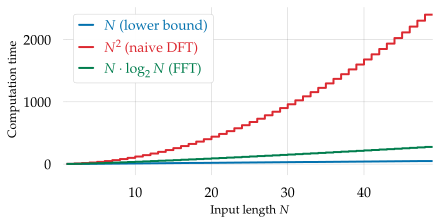

In [20]:
fig, ax = plt.subplots(figsize=figaspect(0.5))

x = np.arange(1, 50)
y = x**2
yl = x * np.log2(x)

ax.step(x, x, label=r'$N$ (lower bound)')
ax.step(x, y, label=r'$N^2$ (naive DFT)')
ax.step(x, yl, label=r'$N\cdot \log_2 N$ (FFT)', color=colors[5])
ax.set(xlabel='Input length $N$', ylabel='Computation time')
ax.legend(loc='upper left', labelcolor='linecolor')
glue('nlogn', fig, display=False)

```{glue:figure} nlogn
:alt: visual comparison of linear, quadratic, and linearithmic time complexity

A comparison of linear ($\blue{N}$), quadratic ($\red{N^2}$), and *linearithmic* ($\green{N \cdot \log_2 N}$) growth.
The linearithmic curve is much gentler than the quadratic curve, meaning that the amount of work increases slowly with the size of the input.
```

## Summary

In this chapter, we've seen that the radix-2 Cooley-Tukey algorithm is substantially faster than the naive DFT implementation.
This is especially true when $N$ is large, as is the common case in audio signal processing.

The code given above for `fft2` is a rather simplistic implementation given to illustrate the basic concepts.
It can be made much more efficient in several ways, including: pre-computing and caching the "twiddle" factors, re-using a single output buffer rather than re-allocating arrays for each partial output, and so on.

The main limitation of the radix-2 method is that it only works if $N$ is an integral power of 2: $N= 1, 2, 4, 8, 16, \dots$.
If $N = 37$ (for example), this method cannot be used.

The radix-2 method is just one special case of the general method of Cooley and Tukey.
In the radix-2 case, we divide an input of length $N$ into 2 inputs of length $N/2$.
More generally, if $N$ is divisible by some integer $p$, we can divide into $p$ inputs of length $N/p$.
The basic principle behind this more general "mixed-radix" approach is the same: the DFTs of the smaller cases are combined to form the larger case by applying the appropriate delay ("twiddle factor") to each one.
This more general approach retains the $N\log N$ computational complexity for broader classes of input length (not just powers of 2).

Where the Cooley-Tukey method fails is when the input length $N$ is a prime number (eg, 37, or 257), and cannot be divided evenly into pieces.
In these cases, alternate methods have been developed which still achieve running time that scales like $N\log N$.

In practice, modern FFT implementations---such as [the Fastest Fourier Transform in the West (FFTW)](http://www.fftw.org/)---use many combinations of strategies to optimize the computation time for a given input length.

The take-home message is that computing DFTs can be done in much less than quadratic time:

```{tip}
The DFT for a signal of $N$ samples can be computed (by FFT methods) in time $\approx N \cdot \log_2 N$.
```